Набор данных $\href{https://www.kaggle.com/competitions/sf-crime}{этого}$ конкурса содержит отчеты о происшествиях почти за 12 лет со всеми приближениями Сан-Франциско. Датасет содержит инциденты, полученные из системы отчетности о преступлениях SFPD. Данные с 01.01.2003 по 13.05.2015. train и test данные чередуются через каждую неделю, то есть недели 1,3,5,7... относятся к test сету , а недели 2,4,6,8 относятся к train сету. train сет содержит категорию с наименованием преступлений, test - id номер.

Поля:
- `Dates` - время совершения преступления
- `Category` - категория происшествия преступления (только в train.csv). Это целевая переменная, которую вы собираетесь прогнозировать.
- `Descript` - подробное описание происшествия (только в train.csv)
- `DayOfWeek` - день недели
- `PdDistrict` - название полицейского округа
- `Resolution` - как было разрешено криминальное происшествие (только в train.csv)
- `Address` - приблизительный адрес места преступления.
- `X` - Долгота
- `Y` - Широта

In [ ]:
!apt-get install -y cuda-libraries-dev-9-0
!pip install pycuda
!pip install scikit-cuda

In [ ]:
!pip install lightgbm xgboost --install-option="--gpu" --no-cache-dir

In [ ]:
!pip install phik shap optuna category_encoders catboost

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
import phik
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

import shap

import optuna
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler 
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [ ]:
path = "drive/MyDrive/"

In [ ]:
df = pd.read_csv(path + "train.csv")
df.shape

(878049, 9)

In [ ]:
test = pd.read_csv(path + "test.csv", index_col='Id')
test.shape

(884262, 6)

In [ ]:
df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [ ]:
test

,Dates,DayOfWeek,PdDistrict,Address,X,Y
Id,,,,,,
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987
884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681
884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075


In [ ]:
# Смотрим дубликаты \ пропуски
df.duplicated().sum()

2323

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.Category.nunique()

39

In [ ]:
df.PdDistrict.value_counts()

SOUTHERN      156528
MISSION       119723
NORTHERN      105105
BAYVIEW        89098
CENTRAL        85267
TENDERLOIN     81642
INGLESIDE      78722
TARAVAL        65400
PARK           49161
RICHMOND       45080
Name: PdDistrict, dtype: int64

In [ ]:
df.Descript.value_counts().head(10)

GRAND THEFT FROM LOCKED AUTO                 59765
LOST PROPERTY                                31498
BATTERY                                      27417
STOLEN AUTOMOBILE                            26866
DRIVERS LICENSE, SUSPENDED OR REVOKED        26823
WARRANT ARREST                               23702
SUSPICIOUS OCCURRENCE                        21878
AIDED CASE, MENTAL DISTURBED                 21488
PETTY THEFT FROM LOCKED AUTO                 19697
MALICIOUS MISCHIEF, VANDALISM OF VEHICLES    17717
Name: Descript, dtype: int64

In [ ]:
df.Resolution.value_counts()

NONE                                      525122
ARREST, BOOKED                            206173
ARREST, CITED                              76832
LOCATED                                    16889
PSYCHOPATHIC CASE                          14529
UNFOUNDED                                   9577
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3969
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3710
JUVENILE CITED                              3322
PROSECUTED BY OUTSIDE AGENCY                2503
EXCEPTIONAL CLEARANCE                       1528
JUVENILE ADMONISHED                         1451
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

In [ ]:
df.Address.value_counts().head(10)

800 Block of BRYANT ST      26245
800 Block of MARKET ST       6576
2000 Block of MISSION ST     5094
1000 Block of POTRERO AV     4046
900 Block of MARKET ST       3245
0 Block of TURK ST           3224
0 Block of 6TH ST            2882
300 Block of ELLIS ST        2701
400 Block of ELLIS ST        2584
16TH ST / MISSION ST         2501
Name: Address, dtype: int64

In [ ]:
df.query('Resolution == "PSYCHOPATHIC CASE" ').Category.unique()

array(['NON-CRIMINAL', 'SECONDARY CODES', 'VANDALISM', 'DRUNKENNESS',
       'SUSPICIOUS OCC', 'ARSON', 'SUICIDE', 'DISORDERLY CONDUCT',
       'MISSING PERSON', 'WARRANTS', 'OTHER OFFENSES', 'ASSAULT',
       'LARCENY/THEFT', 'TRESPASS', 'RUNAWAY', 'DRUG/NARCOTIC',
       'FAMILY OFFENSES', 'PROSTITUTION', 'WEAPON LAWS', 'ROBBERY',
       'FRAUD', 'SEX OFFENSES FORCIBLE', 'VEHICLE THEFT', 'LIQUOR LAWS',
       'FORGERY/COUNTERFEITING', 'DRIVING UNDER THE INFLUENCE',
       'STOLEN PROPERTY', 'EMBEZZLEMENT', 'BURGLARY', 'KIDNAPPING'],
      dtype=object)

In [ ]:
df.query('Resolution == "PSYCHOPATHIC CASE" ').PdDistrict.unique()

array(['PARK', 'SOUTHERN', 'NORTHERN', 'TENDERLOIN', 'CENTRAL', 'TARAVAL',
       'MISSION', 'BAYVIEW', 'RICHMOND', 'INGLESIDE'], dtype=object)

In [ ]:
df.query('Resolution == "LOCATED" ').PdDistrict.unique()

array(['MISSION', 'PARK', 'CENTRAL', 'INGLESIDE', 'BAYVIEW', 'RICHMOND',
       'TENDERLOIN', 'SOUTHERN', 'NORTHERN', 'TARAVAL'], dtype=object)

<AxesSubplot: >

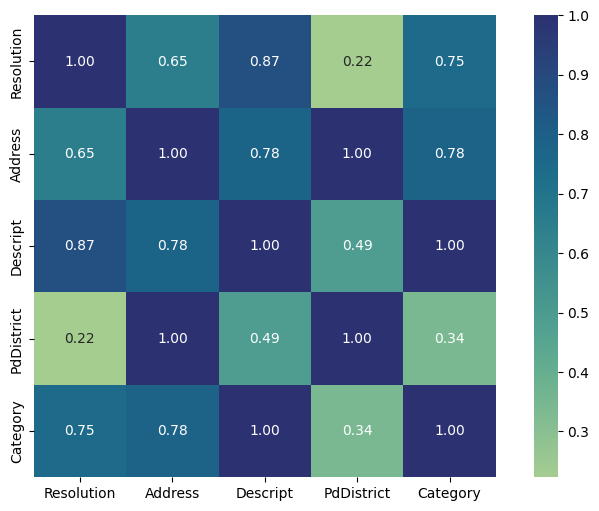

In [ ]:
plt.subplots(figsize=(10, 6))
sns.heatmap(
    df[['Resolution', 'Address', 'Descript',
           'PdDistrict', 'Category']].phik_matrix(),
    cmap="crest",
    cbar=True,
    annot=True,
    square=True,
    fmt='.2f',
)

Resolution и Descript скорее всего мусорные признаки. Descript полностью совпадает с целевой переменной. 

Объединим тестовую и тренировочную выборки

In [ ]:
df['is_test'] = 0
test['is_test'] = 1

raw = pd.concat((df, test)).reset_index(drop=True)

In [ ]:
raw.Dates = pd.to_datetime(raw.Dates)

raw["Date"] = raw.Dates.dt.date
raw["Year"] = raw.Dates.dt.year
raw["Month"] = raw.Dates.dt.month
raw["Day"] = raw.Dates.dt.day
raw["Hour"] = raw.Dates.dt.hour

In [ ]:
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Ночь'
    elif 6 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 18:
        return 'День'
    else:
        return 'Вечер'

In [ ]:
# Создаем новый столбец с категориальным признаком типа часа
raw['time_of_day'] = raw['Dates'].apply(lambda x: get_time_of_day(x.hour))

In [ ]:
holidays = pd.Series(USFederalHolidayCalendar().holidays(start=raw['Dates'].min(), end=raw['Dates'].max()))
raw['is_holiday'] = 'NaN'
raw.loc[raw['Date'].isin(holidays), 'is_holiday'] = 1
raw.loc[raw['is_holiday'] == "NaN", 'is_holiday'] = 0

In [ ]:
raw.is_holiday.value_counts()

0    1761837
1        474
Name: is_holiday, dtype: int64

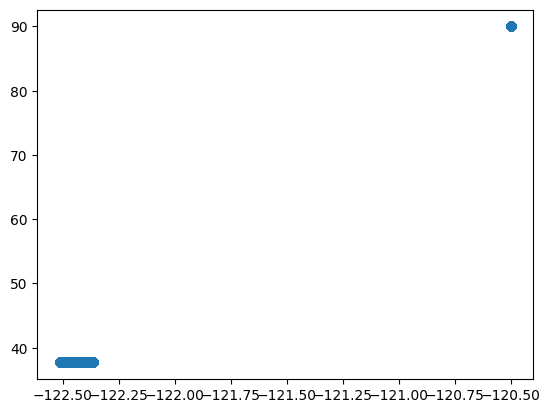

In [ ]:
# Максимальные координаты, особенно по Y, сильно отличаются от средних
# Построим карту координат
plt.scatter(raw.X,raw.Y)
plt.show()

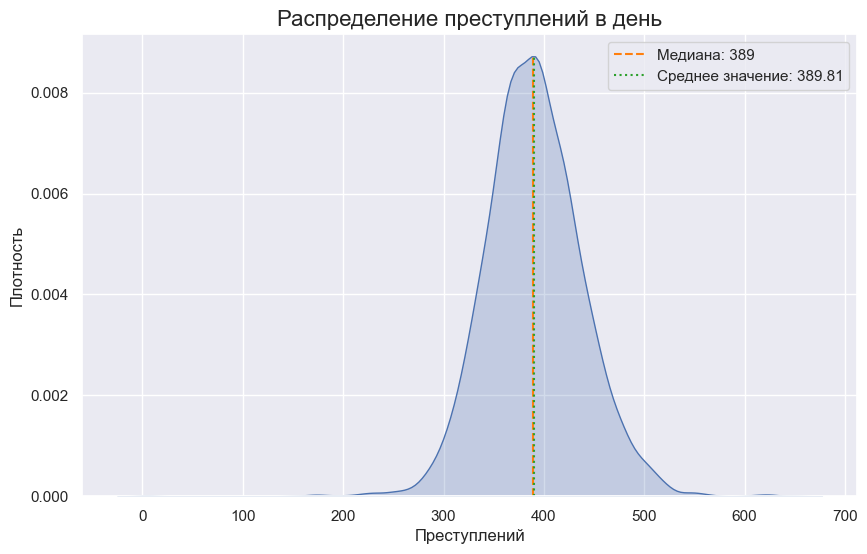

In [ ]:
col = sns.color_palette()
sns.set()

# Cгруппируем данные по дате и посмотирм на распределение
data = raw.groupby('Date').count().iloc[:, 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, shade=True)

plt.axvline(x=data.median(), ymax=0.95, linestyle='--',
            color=col[1], label=f'Медиана: {int(data.median())}')

plt.axvline(x=data.mean(), ymax=0.95, linestyle=':',
            color=col[2], label=f'Cреднее значение: {round(data.mean(), 2)}')
plt.title(
    'Распределение преступлений в день', fontdict={'fontsize': 16})
plt.xlabel('Преступлений')
plt.ylabel('Плотность')
plt.legend()
plt.show()

In [ ]:
def data_hist_plot(df, date_type, title = None, xlabel = None, ylabel = None, rotation = None):

    df = df.groupby(date_type).count().iloc[:, 0]

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df.to_frame().reset_index(), x=date_type, weights="Dates", binwidth=0.5, color="navy", multiple='stack')
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

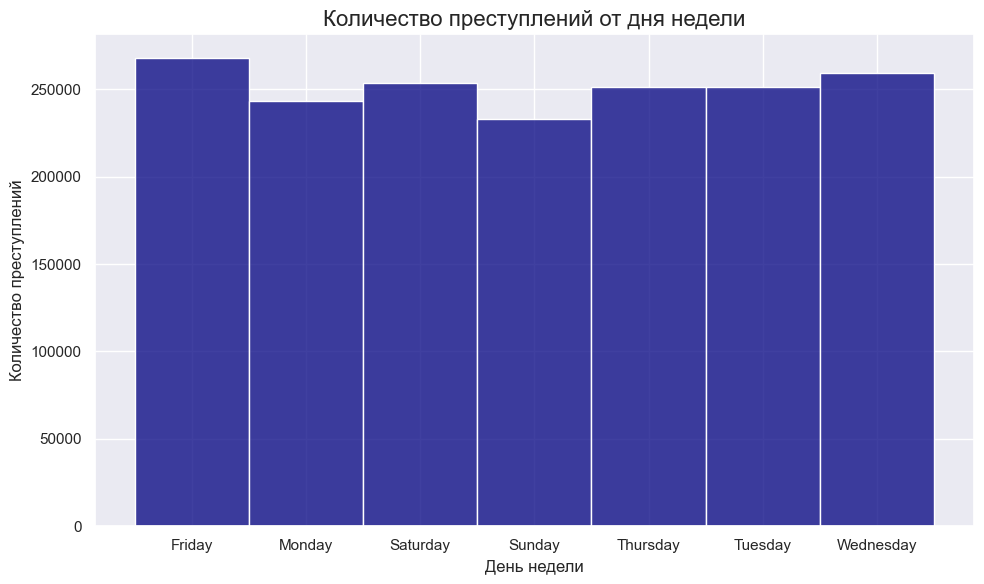

In [ ]:
data_hist_plot(raw, 'DayOfWeek', "Количество преступлений от дня недели", "День недели", "Количество преступлений")

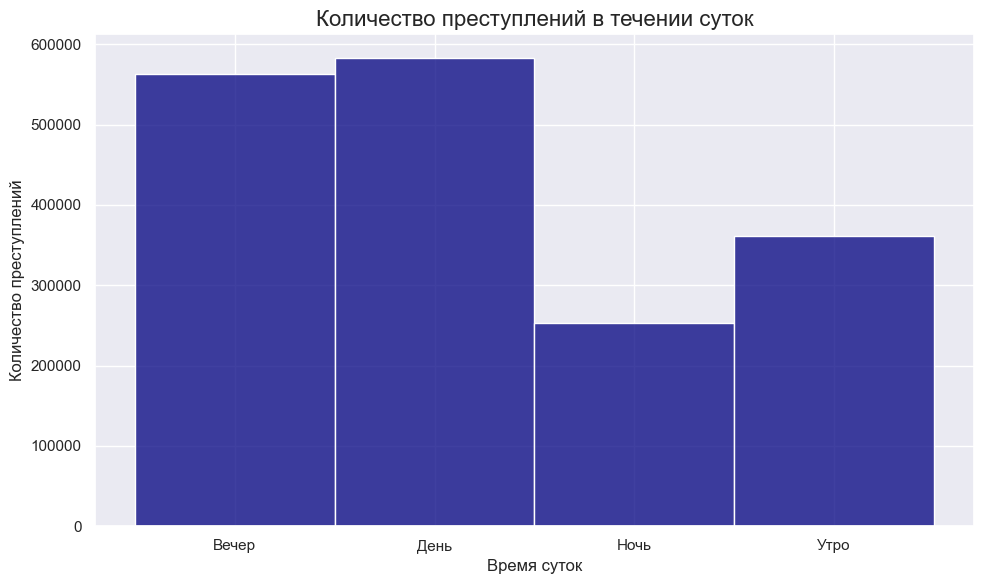

In [ ]:
data_hist_plot(raw, 'time_of_day', "Количество преступлений в течении суток", "Время суток", "Количество преступлений")

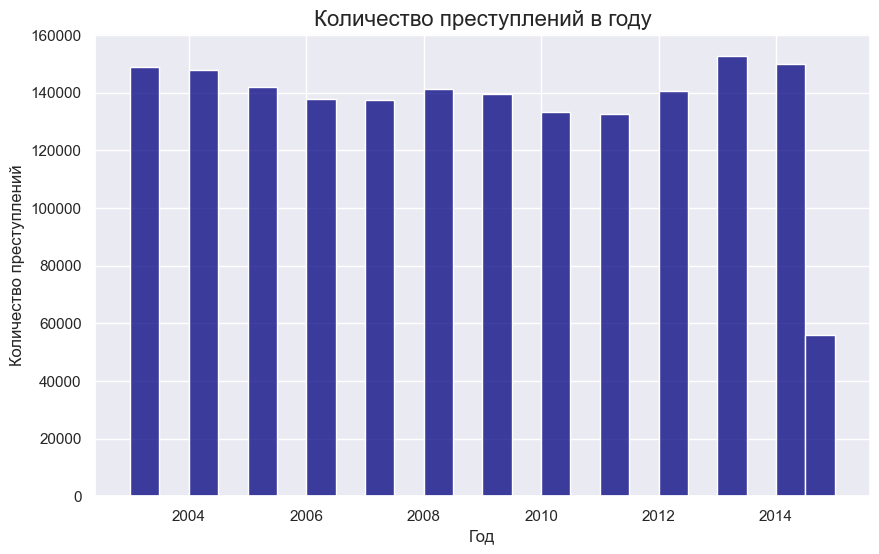

In [ ]:
data_hist_plot(raw, 'Year', "Количество преступлений в году", "Год", "Количество преступлений")

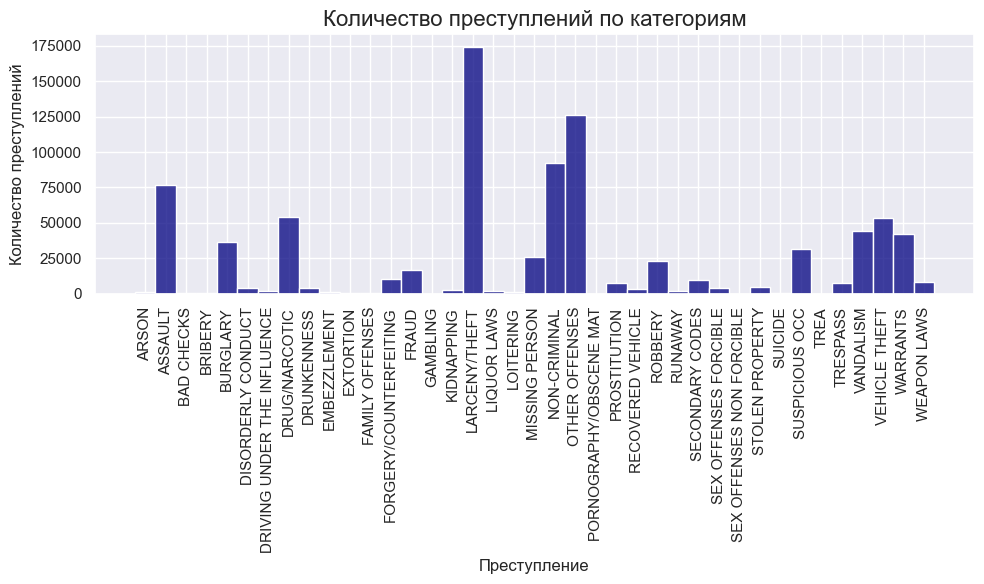

In [ ]:
data_hist_plot(raw, 'Category', "Количество преступлений по категориям", "Преступление", "Количество преступлений", rotation= 90)

# Preprocessing

Заменим выбросы

In [ ]:
raw.loc[raw.Y>40,"Y"] = raw.Y.mean()
df.loc[raw.X>-122,"X"] = raw.X.mean()

Добавим новые фичи

In [ ]:
raw['Block'] = raw['Address'].str.contains('block', case=False).apply(lambda x: 1 if x == True else 0)
raw['ST'] = raw['Address'].str.contains('ST', case=False).apply(lambda x: 1 if x == True else 0)
raw["X_Y"] = raw["X"] - raw["Y"]
raw["XY"] = raw["X"] + raw["Y"]

In [ ]:
test = raw[raw["is_test"] == 1].drop(
    ["Dates", "Category", "Descript", "Resolution", "is_test", "Date", "is_holiday"], axis=1).reset_index(drop = True)

In [ ]:
raw.Address.nunique()

24777

In [ ]:
raw.PdDistrict.nunique()

10

In [ ]:
df = raw[raw["is_test"] == 0].drop(
    ["Dates", "Descript", "Resolution", "is_test", "Date", "is_holiday"], axis=1)

In [ ]:
y = df.Category
X = df.drop("Category", axis = 1)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
y = pd.DataFrame({"Category": y})
y

,Category
0,37
1,21
2,21
3,16
4,16
...,...
875721,25
875722,16
875723,16
875724,35


In [ ]:
encoder = ce.CountEncoder(cols=['Address'])
X = encoder.fit_transform(X)
test = encoder.transform(test)

In [ ]:
# OHE
X = pd.get_dummies(X, drop_first= True)
test = pd.get_dummies(test, drop_first= True)

In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [ ]:
# подберем количество признаков для сжатия PCA
x_rescaled = MinMaxScaler().fit_transform(X_sc)
pca_01 = PCA(n_components = 0.95)                   
optimal_pc = pca_01.fit_transform(x_rescaled)       
print('Достаточное количесвтво компонент(95%):',len(optimal_pc[0])) 
pca_02 = PCA(n_components = 0.99)                   
optimal_pc_02 = pca_02.fit_transform(x_rescaled)
print('Отличное количесвтво компонент(99%):', len(optimal_pc_02[0]))

Достаточное количесвтво компонент(95%): 20
Отличное количесвтво компонент(99%): 23


In [ ]:
# encoder = ce.CountEncoder(cols=['DayOfWeek', 'PdDistrict', 'Address', 'time_of_day'])
# X = encoder.fit_transform(X)

In [ ]:
# test = encoder.transform(test)

In [ ]:
df = pd.concat([X, y], axis= 1)

In [ ]:
# df = pd.DataFrame(X_pca)

In [ ]:
# df["Category"] = y

In [ ]:
def data_preprocessing(df, column, non_scale=False, pca = False):
    df = df.copy()
 # Разбиваем выборку
    X = df.drop(column, axis=1)
    y = df[column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=777)
    
    if pca:
        # Выполняем нормировку данных
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        # уменьшим количество признаков
        pca = PCA(n_components=23)
        X_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        X_train = pd.DataFrame(X_pca)
        X_test = pd.DataFrame(X_test_pca)
        return X_train, X_test, y_train, y_test
    else:
    # Возвращаем значения с нормировкой или без
        if non_scale:
            return X_train, X_test, y_train, y_test
        else:
            # Выполняем нормировку данных
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = pd.DataFrame(scaler.transform(X_train),
                                   index=X_train.index,
                                   columns=X_train.columns)
            X_test = pd.DataFrame(scaler.transform(X_test),
                                  index=X_test.index,
                                  columns=X_test.columns)

            return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = data_preprocessing(df= df, column="Category", pca = True)

# Baseline

In [ ]:
classifiers = {
    "CatBoost": CatBoostClassifier(random_state=777, verbose=False),
    "XGBoost": XGBClassifier(random_state = 777),
    "LGBM": LGBMClassifier(random_state=777),
    "LogisticRegression": LogisticRegression(random_state=777),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=777),

}

LR_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
    'max_iter': [50, 100, 150]
}

KNN_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2]
}

RF_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [4, 6, 8, 10, 12]
}

XGB_grid = {
    "booster": ["gbtree"],
    "tree_method": ["gpu_hist"],
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.15]
}

LGBM_grid = {
    'device_type': ['gpu'],
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.15]
}

Cat_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.15]
}

grid = {
    "LogisticRegression": LR_grid,
    "KNN": KNN_grid,
    "RandomForest": RF_grid,
    "XGBoost": XGB_grid,
    "LGBM": LGBM_grid,
    "CatBoost": Cat_grid,
}

In [ ]:
# Cоздаем переменную в которой будут храниться лучшие модели
clf_best_params = classifiers.copy()
# Создаем таблицу с результатами метрик по каждому из классификаторов
valid_scores = pd.DataFrame({
    'Classifer': classifiers.keys(),
    'Train F1-score macro': np.zeros(len(classifiers)),
    'Test F1-score macro': np.zeros(len(classifiers)),
    'Train F1-score micro': np.zeros(len(classifiers)),
    'Test F1-score micro': np.zeros(len(classifiers)),
    'Train ROC-AUC ovo': np.zeros(len(classifiers)),
    'Test ROC-AUC ovo': np.zeros(len(classifiers)),
    'Train ROC-AUC ovr': np.zeros(len(classifiers)),
    'Test ROC-AUC ovr': np.zeros(len(classifiers)),
    'Train Logloss': np.zeros(len(classifiers)),
    'Test Logloss': np.zeros(len(classifiers)),
    'Training time': np.zeros(len(classifiers))
})

for i, (key, classifier) in tqdm(enumerate(classifiers.items()), total=len(classifiers)):

    print('Модель:', key)

    start = time.time()
    clf = RandomizedSearchCV(classifier, grid[key], n_jobs=-1, cv=3, scoring = 'neg_log_loss')
    # Обучаем модель, подбираем лучшие гиперпараметры
    clf.fit(X_train, y_train)
    clf_best_params[key] = clf.best_params_
    best_clf = clf.best_estimator_
    # Предсказываем 
    y_pred_train = best_clf.predict(X_train)
    y_pred_prob_train = best_clf.predict_proba(X_train)
    y_pred = best_clf.predict(X_test)
    y_pred_prob = best_clf.predict_proba(X_test)
    # Записываем результаты в таблицу
    valid_scores.iloc[i, 1] = f1_score(y_train, y_pred_train, average= "macro")
    valid_scores.iloc[i, 2] = f1_score(y_test, y_pred, average= "macro")
    valid_scores.iloc[i, 3] = f1_score(y_train, y_pred_train, average= "micro")  
    valid_scores.iloc[i, 4] = f1_score(y_test, y_pred, average= "micro")
    valid_scores.iloc[i, 5] = roc_auc_score(y_train, y_pred_prob_train, multi_class='ovo')
    valid_scores.iloc[i, 6] = roc_auc_score(y_test, y_pred_prob, multi_class='ovo')
    valid_scores.iloc[i, 7] = roc_auc_score(y_train, y_pred_prob_train, multi_class='ovr')  
    valid_scores.iloc[i, 8] = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')
    valid_scores.iloc[i, 9] = log_loss(y_train, y_pred_prob_train)
    valid_scores.iloc[i, 10] = log_loss(y_test, y_pred_prob)
    
    stop = time.time()
    valid_scores.iloc[i, -1] = np.round((stop - start), 2)

    # Cоздаем глобальные переменные для дальнейших наблюдений
    var_name = f"{key}_params"
    globals()[var_name] = i
    if key != "LogisticRegression" and key !="KNN":
        param_value = {
            "y_pred": y_pred,
            "pred_proba": best_clf.predict_proba,
            "best_clf": best_clf,
            "feature_importance": best_clf.feature_importances_
        }
    else:
            param_value = {
            "y_pred": y_pred,
            "pred_proba": best_clf.predict_proba,
            "best_clf": best_clf
        }
        
    globals()[var_name] = param_value

    print('Время обучения (мин):', np.round((stop - start) / 60, 2))
    print('---------------------------------------------')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Модель: XGBoost


 50%|█████████████████████████████████████████                                         | 1/2 [25:38<25:38, 1538.00s/it]

Время обучения (мин): 25.63
---------------------------------------------
Модель: RandomForest


100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:28:31<00:00, 2655.80s/it]

Время обучения (мин): 62.89
---------------------------------------------


In [ ]:
# Записываем в таблицу
valid_scores.to_csv("scores.csv", index= False)
# Смотрим метрики каждого алгоритма с подобранными параметрами через GridSearch 
valid_scores

,Classifer,Train F1-score macro,Test F1-score macro,Train F1-score micro,Test F1-score micro,Train ROC-AUC ovo,Test ROC-AUC ovo,Train ROC-AUC ovr,Test ROC-AUC ovr,Train Logloss,Test Logloss,Training time
0,CatBoost,0.188254,0.097106,0.307763,0.288142,0.879052,0.728264,0.879125,0.734538,2.223770,2.367415,7917.06
1,XGBoost,0.169917,0.101303,0.307017,0.288286,0.874659,0.730718,0.876533,0.736351,2.235152,2.362673,1412.44
2,LGBM,0.112565,0.084350,0.277864,0.274286,0.794387,0.710976,0.796078,0.716109,2.376120,2.412283,6322.68
3,LogisticRegression,0.017813,0.017578,0.205580,0.205555,0.622737,0.604545,0.635106,0.616797,2.626600,2.628805,406.61
4,KNN,0.138013,0.057023,0.347379,0.200340,0.949802,0.563134,0.951212,0.564919,1.610479,14.312214,4609.23
5,RandomForest,0.079383,0.071685,0.299702,0.278980,0.881608,0.714683,0.889923,0.724266,2.274973,2.400976,1099.91


In [ ]:
valid_scores.to_csv("valid_scores_pca095.csv", index= False)
valid_scores

,Classifer,Train F1-score macro,Test F1-score macro,Train F1-score micro,Test F1-score micro,Train ROC-AUC ovo,Test ROC-AUC ovo,Train ROC-AUC ovr,Test ROC-AUC ovr,Train Logloss,Test Logloss,Training time
0,CatBoost,0.070773,0.064713,0.276765,0.269251,0.824022,0.703714,0.835807,0.721846,2.356613,2.414704,11523.36
1,XGBoost,0.221269,0.084312,0.305565,0.275581,0.893348,0.697618,0.891263,0.711274,2.220999,2.399559,2096.67
2,LGBM,0.106594,0.064272,0.263279,0.260271,0.801965,0.692154,0.805968,0.707984,2.413215,2.450752,5277.71
3,LogisticRegression,0.029387,0.029614,0.229979,0.231046,0.678415,0.652960,0.697798,0.674249,2.549259,2.550963,414.86
4,KNN,0.146288,0.064138,0.358906,0.215634,0.951239,0.570863,0.953165,0.573365,1.579226,13.930626,6423.34
5,RandomForest,0.062983,0.053961,0.287282,0.263659,0.859070,0.697780,0.870297,0.716942,2.324590,2.441561,2795.99


In [ ]:
valid_scores.to_csv("valid_scores_pca099.csv", index= False)
valid_scores

,Classifer,Train F1-score macro,Test F1-score macro,Train F1-score micro,Test F1-score micro,Train ROC-AUC ovo,Test ROC-AUC ovo,Train ROC-AUC ovr,Test ROC-AUC ovr,Train Logloss,Test Logloss,Training time
0,XGBoost,0.246116,0.089419,0.310213,0.275695,0.900098,0.717619,0.896216,0.728769,2.193572,2.394617,1537.99
1,RandomForest,0.071889,0.059803,0.289517,0.263868,0.865065,0.699997,0.875357,0.717964,2.308878,2.433378,3773.56


# Feature engineering

In [ ]:
# Смотрим на важность признаков по MDI
Cat_feature_importances = CatBoost_params["feature_importance"]
XGB_feature_importances = XGBoost_params["feature_importance"]
RF_feature_importances = RandomForest_params["feature_importance"]

feature_importances_df = pd.DataFrame({
    'features': list(X_train),
    'Cat_feature_importances': Cat_feature_importances,
    'XGB_feature_importances': XGB_feature_importances,
    'RF_feature_importances': RF_feature_importances,
})
feature_importances_df.sort_values(by = "Cat_feature_importances",ascending= False)

,features,Cat_feature_importances,XGB_feature_importances,RF_feature_importances
4,Y,16.285795,0.140883,0.242237
2,Address,15.871328,0.158657,0.186087
3,X,15.307824,0.135921,0.204525
5,Year,12.670537,0.098460,0.079787
8,Hour,11.203573,0.113169,0.079662
7,Day,6.651640,0.037413,0.036266
6,Month,6.525313,0.038302,0.029060
1,PdDistrict,6.291542,0.148020,0.086770
0,DayOfWeek,6.033476,0.044936,0.024632
9,time_of_day,3.156729,0.068549,0.030775


In [ ]:
feature_importances_df.sort_values(by = "Cat_feature_importances",ascending= False).to_csv("feature_importances_mdi")

In [ ]:
# Стандартизируем значения важности признаков
scaler = StandardScaler()
cols_to_scale = ['Cat_feature_importances', 'XGB_feature_importances', 'RF_feature_importances']
feature_importances_df[cols_to_scale] = scaler.fit_transform(feature_importances_df[cols_to_scale])

In [ ]:
df_melt = pd.melt(feature_importances_df, id_vars=['features'], value_vars=['Cat_feature_importances', 'XGB_feature_importances', 'RF_feature_importances'],
                  var_name='feature_importances', value_name='value')

<AxesSubplot: xlabel='features', ylabel='value'>

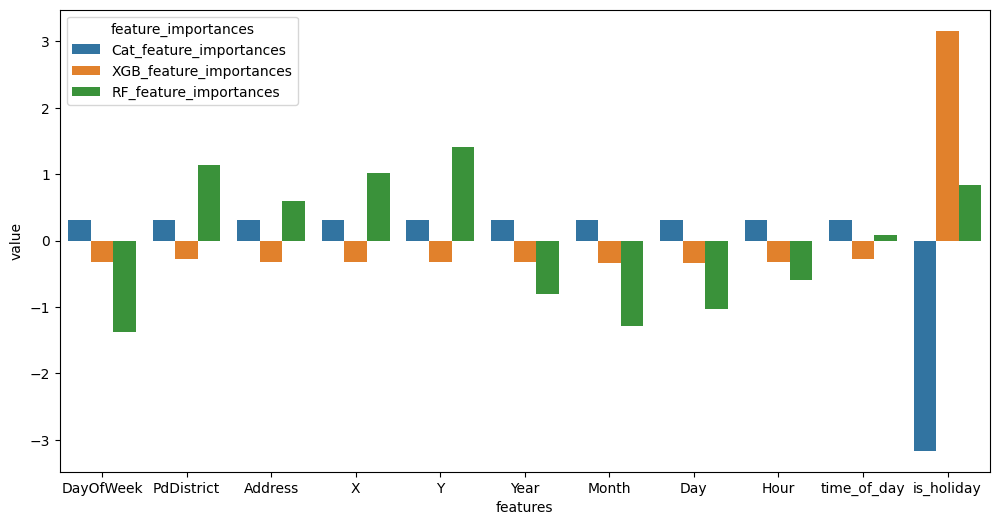

In [ ]:
# Выводим график важности фичей
plt.figure(figsize= (12, 6))
sns.barplot(data=df_melt, x='features', y='value', hue='feature_importances')


In [ ]:
# Создаем базовую палитру из 20 цветов
base_palette = plt.cm.get_cmap('tab20')

# Создаем список из 39 цветов, повторяя цвета базовой палитры
colors = [base_palette(i % 20) for i in range(39)]

# Создаем новую палитру на основе списка цветов
cmap = mpl.colors.ListedColormap(colors)

In [ ]:
# Cчитаем важность фичей через Shap для Catboost
explainer = shap.TreeExplainer(CatBoost_params['best_clf'])
shap_values = explainer.shap_values(X_train)

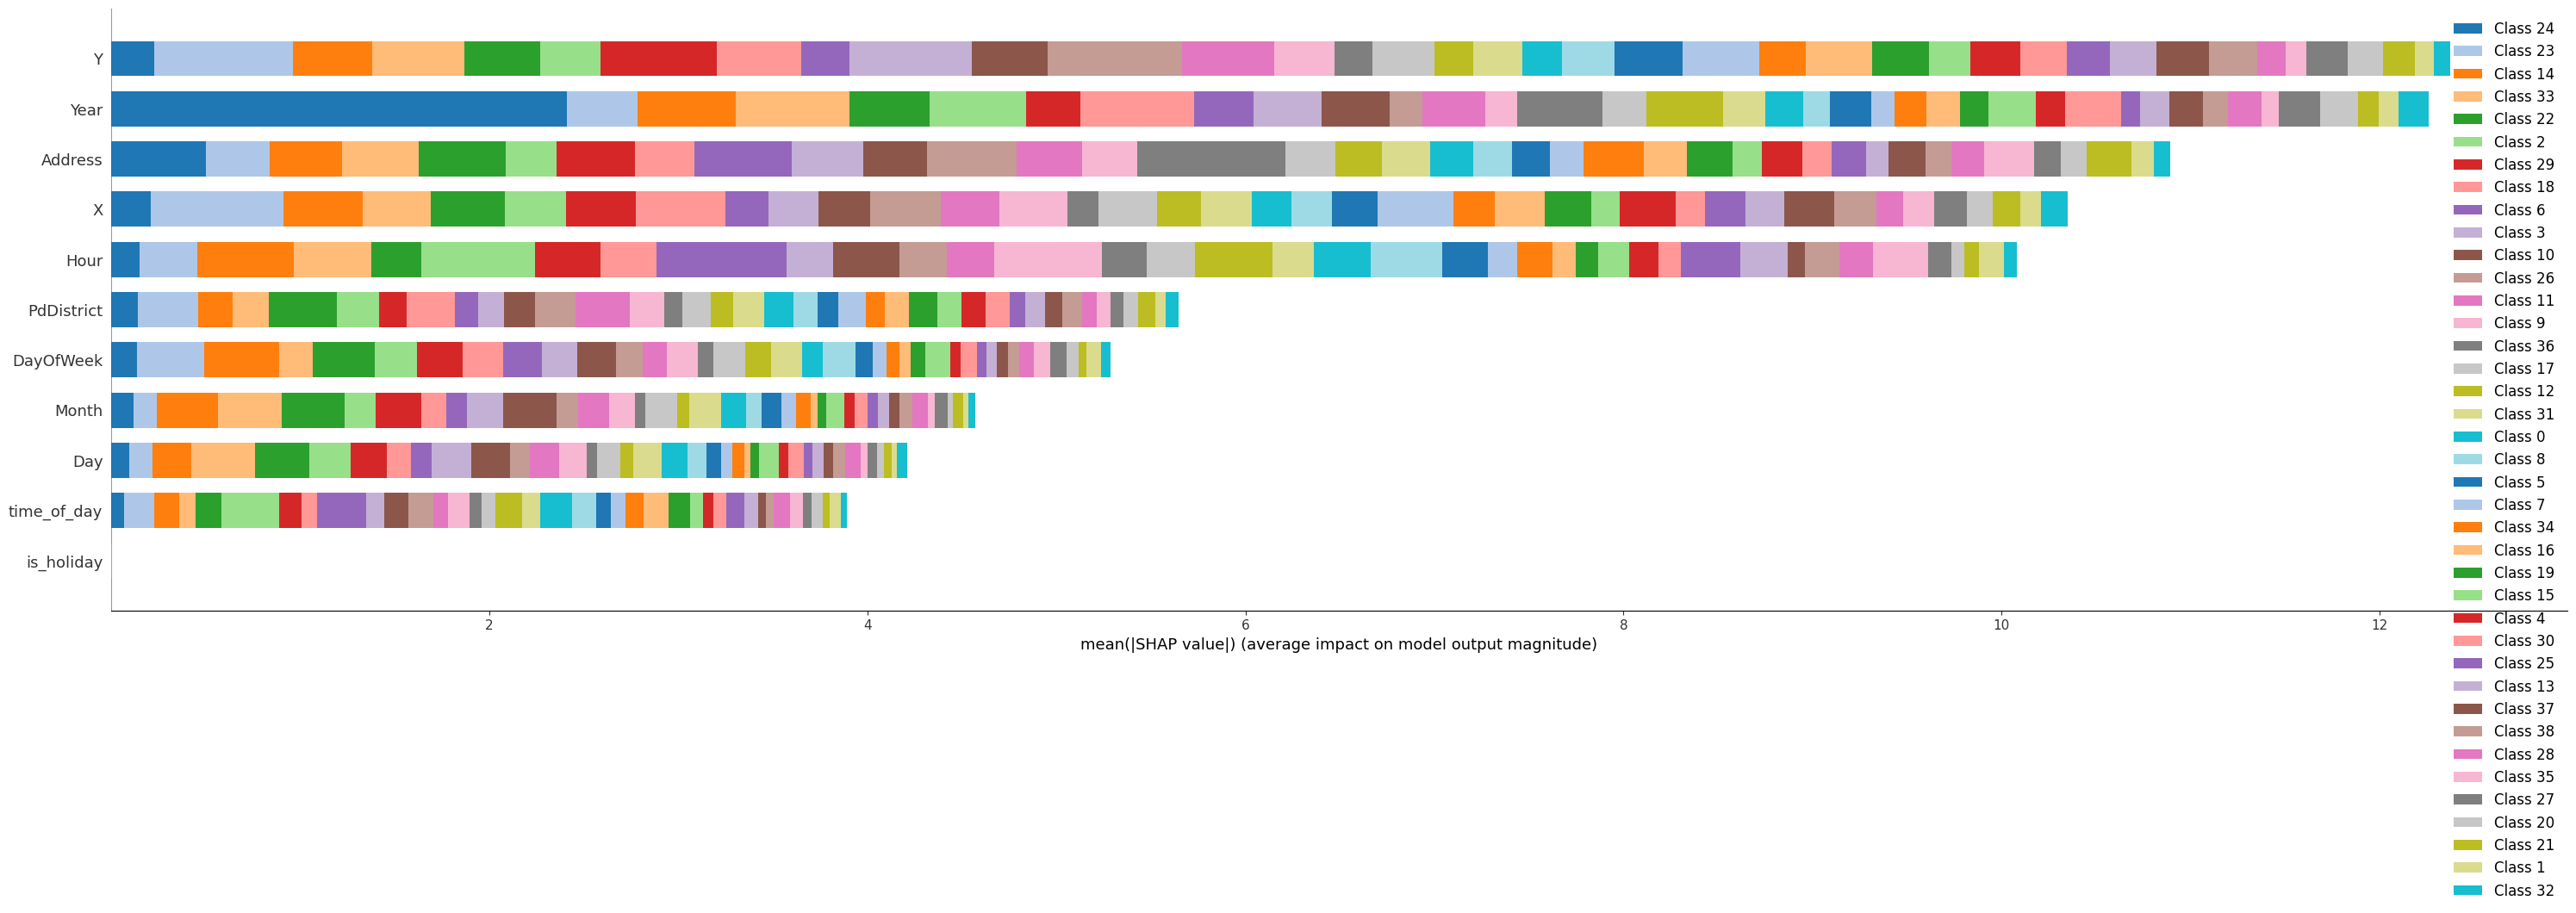

In [ ]:
shap.summary_plot(shap_values, X_train, plot_size=(30,10),color=cmap, title= "Важность признаков в CatBoost")

In [ ]:
# Cчитаем важность фичей через Shap для XGBoost
xgb_explainer = shap.TreeExplainer(XGBoost_params['best_clf'])
xgb_shap_values = xgb_explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(xgb_shap_values, X_train, plot_size=(30,10),color=cmap, title= "Важность признаков в XGBoost")

In [ ]:
# Удаляем мусорный признак
df.drop(['is_holiday'], axis = 1, inplace = True)

In [ ]:
test.drop(['is_holiday'], axis = 1, inplace = True)

In [ ]:
# Дополняем самые маленькие классы
df.Category.value_counts().tail(10)

9     1164
31     508
11     488
2      406
3      289
10     256
29     148
14     146
22      22
33       6
Name: Category, dtype: int64

In [ ]:
cat_33 = df.query("Category == 33")
cat_22 = df.query("Category == 22")
# cat_14 = df.query("Category == 14")
# cat_29 = df.query("Category == 29")
# cat_10 = df.query("Category == 10")
# cat_2 = df.query("Category == 2")
# cat_3 = df.query("Category == 3")
# cat_11 = df.query("Category == 11")
# cat_31 = df.query("Category == 31")

In [ ]:
cat_33_upsampled = resample(cat_33, replace= True, n_samples= 60)
cat_22_upsampled = resample(cat_22, replace= True, n_samples= 120)
# cat_14_upsampled = resample(cat_14, replace= True, n_samples= 200)
# cat_29_upsampled = resample(cat_29, replace= True, n_samples= 200)
# cat_10_upsampled = resample(cat_10, replace= True, n_samples= 1100)
# cat_2_upsampled = resample(cat_2, replace= True, n_samples= 1100)
# cat_3_upsampled = resample(cat_3, replace= True, n_samples= 1100)
# cat_11_upsampled = resample(cat_11, replace= True, n_samples= 1100)
# cat_31_upsampled = resample(cat_31, replace= True, n_samples= 1100)

In [ ]:
# df = df.query("Category != 33 & Category != 22 & Category != 14 & Category != 29 & Category != 10 & Category != 2 & Category != 3 & Category != 11 & Category != 31")
df = df.query("Category != 33 & Category != 22")

In [ ]:
#df = pd.concat([df, cat_39_upsampled, cat_22_upsampled, cat_14_upsampled, cat_29_upsampled, cat_10_upsampled, cat_2_upsampled, cat_3_upsampled, cat_11_upsampled, cat_31_upsampled])
df = pd.concat([df, cat_33_upsampled, cat_22_upsampled])

In [ ]:
df.Category.value_counts().tail(10)

9     1164
31     508
11     488
2      406
3      289
10     256
29     148
14     146
22     120
33      60
Name: Category, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = data_preprocessing(df= df, column="Category")

In [ ]:
X_train

,Address,X,Y,Year,Month,Day,Hour,Block,ST,X_Y,...,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN,time_of_day_День,time_of_day_Ночь,time_of_day_Утро
683966,-0.208540,-1.658668,-2.131750,-1.024272,0.455814,1.074019,-2.047132,0.650718,-2.003501,0.012848,...,-0.398302,-0.369846,-0.24362,-0.233123,-0.466417,3.521146,-0.320640,-0.704450,2.442916,-0.507602
439372,-0.179143,0.153433,0.750290,0.077307,-1.001855,-1.317945,-1.436446,-1.536765,0.499126,-0.366190,...,-0.398302,-0.369846,-0.24362,-0.233123,-0.466417,-0.283998,3.118758,-0.704450,2.442916,-0.507602
178960,-0.241502,0.399415,1.634019,0.903491,1.621949,1.301825,0.395610,0.650718,0.499126,-0.742663,...,-0.398302,-0.369846,-0.24362,-0.233123,-0.466417,-0.283998,-0.320640,1.419546,-0.409347,-0.507602
212084,-0.258205,0.041967,0.415905,0.903491,0.164280,-0.292818,1.311639,-1.536765,0.499126,-0.239198,...,-0.398302,2.703832,-0.24362,-0.233123,-0.466417,-0.283998,-0.320640,-0.704450,-0.409347,-0.507602
379104,-0.252860,0.848158,1.025140,0.352702,-1.584923,1.074019,-0.825761,0.650718,0.499126,0.036278,...,-0.398302,-0.369846,-0.24362,-0.233123,2.144006,-0.283998,-0.320640,-0.704450,-0.409347,1.970049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16247,-0.195623,0.212884,0.720588,1.729675,-1.293389,0.618407,0.700953,-1.536765,0.499126,-0.296627,...,-0.398302,-0.369846,-0.24362,-0.233123,-0.466417,-0.283998,3.118758,-0.704450,-0.409347,-0.507602
285489,-0.259096,-1.056875,0.353953,0.628096,-0.127254,-0.065012,1.311639,0.650718,0.499126,-1.121784,...,-0.398302,-0.369846,-0.24362,4.289580,-0.466417,-0.283998,-0.320640,-0.704450,-0.409347,-0.507602
202722,-0.225021,0.063816,0.954508,0.903491,0.747347,-1.431848,1.158967,0.650718,0.499126,-0.576274,...,-0.398302,2.703832,-0.24362,-0.233123,-0.466417,-0.283998,-0.320640,-0.704450,-0.409347,-0.507602
631202,5.575503,0.624800,0.346784,-0.748877,-0.418788,0.504504,1.158967,0.650718,0.499126,0.296232,...,-0.398302,-0.369846,-0.24362,-0.233123,2.144006,-0.283998,-0.320640,-0.704450,-0.409347,-0.507602


# Optuna hyperparam optimizacion

In [ ]:
def RF_objective(trial):
    params = {
        "n_jobs": -1,
        'random_state': 777,
        'n_estimators': trial.suggest_int("n_estimators", 10, 1000),
        'max_depth':  trial.suggest_int("max_depth", 2, 32, log=True),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 50),
    }
    Rf_clf = RandomForestClassifier(**params)

    Rf_clf.fit(X_train, y_train)
    y_pred = Rf_clf.predict_proba(X_test)
    score = log_loss(y_test, y_pred)

    return score

In [ ]:
rf_study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=5, max_resource=100, reduction_factor=3
    )
)
rf_study.optimize(RF_objective, n_trials=50,
                #  n_jobs=-1
                 )

[I 2023-03-15 14:53:46,126] A new study created in memory with name: no-name-faae9a8f-c6d2-407a-8b37-1c760ab29ac4
[I 2023-03-15 15:04:44,203] Trial 0 finished with value: 2.415875572370341 and parameters: {'n_estimators': 702, 'max_depth': 16, 'min_samples_split': 75, 'min_samples_leaf': 45}. Best is trial 0 with value: 2.415875572370341.
[I 2023-03-15 15:05:07,957] Trial 1 finished with value: 2.5917566094504 and parameters: {'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 33, 'min_samples_leaf': 44}. Best is trial 0 with value: 2.415875572370341.
[I 2023-03-15 15:05:37,108] Trial 2 finished with value: 2.4386686454560387 and parameters: {'n_estimators': 33, 'max_depth': 13, 'min_samples_split': 75, 'min_samples_leaf': 50}. Best is trial 0 with value: 2.415875572370341.
[I 2023-03-15 15:15:00,788] Trial 3 finished with value: 2.4096483186387756 and parameters: {'n_estimators': 573, 'max_depth': 17, 'min_samples_split': 92, 'min_samples_leaf': 18}. Best is trial 3 with value: 

In [ ]:
rf = rf_study.trials_dataframe()

In [ ]:
rf.to_csv('rf_optuna_logs_pca.csv')

In [ ]:
optuna.visualization.plot_optimization_history(rf_study)

In [ ]:
def XGBoost_objective(trial):
    params = {
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
             "num_class": 39,
            "booster": "gbtree",
            "tree_method": "gpu_hist",
            "random_state": 777,
            "n_jobs": -1,
            "verbosity": 0,
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 1, 16, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "subsample": trial.suggest_float("subsample", 0.1, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1.0, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
        }        
    XGB_clf = XGBClassifier(**params)

    XGB_clf.fit(X_train, y_train)
    y_pred = XGB_clf.predict_proba(X_test)
    score = log_loss(y_test, y_pred)

    return score

In [ ]:
XGB_study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=5, max_resource=100, reduction_factor=3
    )
)
XGB_study.optimize(XGBoost_objective, n_trials=50)

[I 2023-03-15 10:56:00,852] A new study created in memory with name: no-name-aa2948e4-c885-4ded-9c36-55c915e022e4
[I 2023-03-15 10:58:56,050] Trial 0 finished with value: 2.3947330197528136 and parameters: {'n_estimators': 681, 'max_depth': 5, 'learning_rate': 0.0524743970277671, 'subsample': 0.7994317634133374, 'gamma': 0.6045899835034567, 'reg_alpha': 0.32287792306532603, 'reg_lambda': 0.18424998641471696, 'min_child_weight': 6}. Best is trial 0 with value: 2.3947330197528136.
[I 2023-03-15 11:03:26,968] Trial 1 finished with value: 2.399856388271622 and parameters: {'n_estimators': 847, 'max_depth': 7, 'learning_rate': 0.05156804633992696, 'subsample': 0.2605400389011248, 'gamma': 0.4959066017163969, 'reg_alpha': 0.2303758262497177, 'reg_lambda': 0.2453294065439546, 'min_child_weight': 7}. Best is trial 0 with value: 2.3947330197528136.
[I 2023-03-15 11:05:00,124] Trial 2 finished with value: 2.5203651060339025 and parameters: {'n_estimators': 784, 'max_depth': 1, 'learning_rate': 0

[I 2023-03-15 12:05:00,199] Trial 21 finished with value: 2.3659017847925234 and parameters: {'n_estimators': 364, 'max_depth': 16, 'learning_rate': 0.06510170046476087, 'subsample': 0.9429877248787104, 'gamma': 0.997465146151375, 'reg_alpha': 0.23051509105149565, 'reg_lambda': 0.027825908310195057, 'min_child_weight': 10}. Best is trial 21 with value: 2.3659017847925234.
[I 2023-03-15 12:10:03,501] Trial 22 finished with value: 2.3705513392993685 and parameters: {'n_estimators': 218, 'max_depth': 16, 'learning_rate': 0.062027854474360225, 'subsample': 0.9051530529982137, 'gamma': 0.7228127687755903, 'reg_alpha': 0.18232732314848374, 'reg_lambda': 0.03140103265773622, 'min_child_weight': 8}. Best is trial 21 with value: 2.3659017847925234.
[I 2023-03-15 12:14:25,482] Trial 23 finished with value: 2.3767111789052446 and parameters: {'n_estimators': 563, 'max_depth': 8, 'learning_rate': 0.04097039492364144, 'subsample': 0.8209945139431756, 'gamma': 0.8949753485273721, 'reg_alpha': 0.0820

[I 2023-03-15 13:28:03,032] Trial 43 finished with value: 2.378449264381428 and parameters: {'n_estimators': 382, 'max_depth': 9, 'learning_rate': 0.0879240357976588, 'subsample': 0.8487472084324934, 'gamma': 0.26398952675423426, 'reg_alpha': 0.31844197560900483, 'reg_lambda': 0.014748830452847118, 'min_child_weight': 8}. Best is trial 40 with value: 2.365172544659494.
[I 2023-03-15 13:39:27,314] Trial 44 finished with value: 2.3710329655299534 and parameters: {'n_estimators': 488, 'max_depth': 14, 'learning_rate': 0.013999375740963573, 'subsample': 0.9584957955242472, 'gamma': 0.33751217291970803, 'reg_alpha': 0.5077291932946341, 'reg_lambda': 0.05217653278481093, 'min_child_weight': 10}. Best is trial 40 with value: 2.365172544659494.
[I 2023-03-15 13:43:48,860] Trial 45 finished with value: 2.3671516700691666 and parameters: {'n_estimators': 238, 'max_depth': 11, 'learning_rate': 0.04087538085957677, 'subsample': 0.9062247232700886, 'gamma': 0.14934596043375659, 'reg_alpha': 0.10647

In [ ]:
xgb = XGB_study.trials_dataframe()
xgb.to_csv('XGBM_optuna_logs_pca.csv')

In [ ]:
optuna.visualization.plot_optimization_history(XGB_study)

In [ ]:
def LGBM_objective(trial):
    params = {
            # 'device': 'gpu',
            "objective": "multiclass",
            "metric": "multi_logloss",
            "num_class": 39,
            "boosting_type": "gbdt",
            "random_state": 777,
            "n_jobs": -1,
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 2, 16, log=True),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "subsample": trial.suggest_float("subsample", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1.0, log=True)
        }
    LGBM_clf = LGBMClassifier(device='gpu', **params)

    LGBM_clf.fit(X_train, y_train)
    y_pred = LGBM_clf.predict_proba(X_test)
    score = log_loss(y_test, y_pred)

    return score

In [ ]:
LGBM_study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=5, max_resource=100, reduction_factor=3
    )
)
LGBM_study.optimize(LGBM_objective, n_trials=50)

In [ ]:
lgbm = LGBM_study.trials_dataframe()
lgbm.to_csv('LGBM_optuna_logs.csv')

In [ ]:
optuna.visualization.plot_optimization_history(LGBM_study)

In [ ]:
def Cat_objective(trial):
    params = {
            "task_type": 'GPU',
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'random_seed': 777,
            'loss_function': 'MultiClass',
            'depth': trial.suggest_int('depth', 1, 16),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1.0),
            'random_strength': trial.suggest_float("random_strength", 1e-3, 1.0, log=True),
        }
    Cat_clf = CatBoostClassifier(**params, verbose=False)

    Cat_clf.fit(X_train, y_train)
    y_pred = Cat_clf.predict_proba(X_test)
    score = log_loss(y_test, y_pred)

    return score

In [ ]:
Cat_study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=5, max_resource=100, reduction_factor=3
    )
)
Cat_study.optimize(Cat_objective, n_trials=50)

In [ ]:
cat = Cat_study.trials_dataframe()
cat.to_csv('Cat_optuna_logs.csv')

In [ ]:
optuna.visualization.plot_optimization_history(Cat_study)

# Train model

In [ ]:
#   Гиперпараметры без РСА и OHE
best_params = {
    "RF": {
        "n_jobs": -1,
        "random_state": 777,
        'n_estimators': 997,
        'max_depth': 19,
        'min_samples_split': 4,
        'min_samples_leaf': 3
    },

    "XGBoost": {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": 39,
        "booster": "gbtree",
        "tree_method": "gpu_hist",
        "random_state": 777,
        "n_jobs": -1,
        "verbosity": 0,
        'n_estimators': 859,
        'max_depth': 16,
        'learning_rate': 0.010295947864357634,
        'subsample': 0.8748755339602003,
        'gamma': 0.9990477688940191,
        'reg_alpha': 9.00038342071672e-05,
        'reg_lambda': 0.8057272934902254,
        'min_child_weight': 1},
# }
# #   Гиперпараметры с РСА и OHE
# best_params = {
#     "XGBoost": {
#         "objective": "multi:softprob",
#         "eval_metric": "mlogloss",
#         "num_class": 39,
#         "booster": "gbtree",
#         "tree_method": "gpu_hist",
#         "random_state": 777,
#         "n_jobs": -1,
#         "verbosity": 0,
#         'n_estimators': 354,
#         'max_depth': 14,
#         'learning_rate': 0.0347541926219132,
#         'subsample': 0.7976878382908568,
#         'gamma': 0.4264031839980438,
#         'reg_alpha': 0.7594267221343212,
#         'reg_lambda': 0.02732031706370307,
#         'min_child_weight': 9
#     },
# }
#   Гиперпараметры с new feature
# best_params = {
#     "RF": {
#         "n_jobs": -1,
#         "random_state": 777,
#         'n_estimators': 755,
#         'max_depth': 21, 
#         'min_samples_split': 9,
#         'min_samples_leaf': 3
#     },

#     "XGBoost": {
#         "objective": "multi:softprob",
#         "eval_metric": "mlogloss",
#         "num_class": 39,
#         "booster": "gbtree",
#         "tree_method": "gpu_hist",
#         "random_state": 777,
#         "n_jobs": -1,
#         "verbosity": 0,
#         'n_estimators': 687,
#         'max_depth': 13,
#         'learning_rate': 0.01936418904671521,
#         'subsample': 0.8864513503612127,
#         'gamma': 0.5198812737840048,
#         'reg_alpha': 0.7629048170735654,
#         'reg_lambda': 0.015784277794507678,
#         'min_child_weight': 3
#     },
# }

In [ ]:
best_models = {
    "RF" : RandomForestClassifier(**best_params['RF']),

    "XGBoost" : XGBClassifier(**best_params['XGBoost']),
}

In [ ]:
# Дебажим код, чтоб не обучать на всем df
df_filtered = df.groupby('Category').apply(lambda x: x.sample(n=20, replace=True)).reset_index(drop=True)

In [ ]:
logloss_dict = {'model': [], 'logloss_train': [],'logloss_valid': [] }
preds_dict = {}
folds = 10

X = df.drop(["Category"], axis= 1)
y = df.Category

for clf_num, (key, classifier) in tqdm(enumerate(best_models.items()), total=len(best_models)):
    start = time.time()

    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=777)
    
    # Создаем матрицу предсказаний и метрик для каждого classifier
    preds = np.zeros((len(test), 39))
    log_loss_score_train = np.zeros(folds)
    log_loss_score_valid = np.zeros(folds)
    
    print('Модель:', key)
    
    for fold, (train_idx, valid_idx) in tqdm(enumerate(cv.split(X, y)), total=folds):
        # Разбиваем выборку на тренировочную и валидационную
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Нормируем выборки
        scaler = StandardScaler()
        scaler.fit(X_train_fold)
        X_train_fold = scaler.transform(X_train_fold)
        X_valid_fold = scaler.transform(X_valid_fold)

        # Обучаем модель
        clf = classifier
        clf.fit(X_train_fold, y_train_fold)

        # Делаем предсказания и записываем метрику
        y_pred_fold = clf.predict_proba(X_valid_fold)
        y_pred_train_fold = clf.predict_proba(X_train_fold)
        preds += clf.predict_proba(scaler.transform(test))
        log_loss_score_train[fold] = log_loss(y_train_fold, y_pred_train_fold, labels=np.unique(y_train_fold))
        log_loss_score_valid[fold] = log_loss(y_valid_fold, y_pred_fold, labels=np.unique(y_valid_fold))
        
    # Добавлем значения logloss для каждой модели в словарь
    logloss_dict['model'].append(key)
    logloss_dict['logloss_train'].append(np.mean(log_loss_score_train))
    logloss_dict['logloss_valid'].append(np.mean(log_loss_score_valid))
    
    # Фиксируем время обучения
    stop = time.time()
    # Записываем предсказания в словарь
    preds /= folds
    preds_dict[key] = preds
    
    # Выводим в консоль модель, время обучения на 10-ти фолдах и метрику
    print('Время обучения (мин):', np.round((stop - start) / 60 , 2))
    print('log_loss для модели:', np.mean(log_loss_score_valid))
    print('-----------------------------------------------------------------------------------')

# # PCA
# logloss_dict = {'model': [], 'logloss_train': [],'logloss_valid': [] }
# preds_dict = {}
# folds = 10

# X = df.drop(["Category"], axis= 1)
# y = df.Category

# for clf_num, (key, classifier) in tqdm(enumerate(best_models.items()), total=len(best_models)):
#     start = time.time()

#     cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=777)
    
#     # Создаем матрицу предсказаний и метрик для каждого classifier
#     preds = np.zeros((len(test1), 39))
#     log_loss_score_train = np.zeros(folds)
#     log_loss_score_valid = np.zeros(folds)
    
#     print('Модель:', key)
    
#     for fold, (train_idx, valid_idx) in tqdm(enumerate(cv.split(X, y)), total=folds):
#         # Разбиваем выборку на тренировочную и валидационную
#         X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Нормируем выборки
        # scaler = StandardScaler()
        # scaler.fit(X_train_fold)
        # X_train_fold = scaler.transform(X_train_fold)
        # X_valid_fold = scaler.transform(X_valid_fold)
        # pca = PCA(n_components=23)
        # X_pca = pca.fit(X_train_fold)
        # test1 = scaler.transform(test)
        # test1 = pca.transform(test)
        
#         X_train_pca = pca.fit_transform(X_train_fold)
#         X_valid_pca = pca.transform(X_valid_fold)

#         # Обучаем модель
#         clf = classifier
#         clf.fit(X_train_pca, y_train_fold)

#         # Делаем предсказания и записываем метрику
#         y_pred_fold = clf.predict_proba(X_valid_pca)
#         y_pred_train_fold = clf.predict_proba(X_train_pca)
#         preds += clf.predict_proba(test1)
#         log_loss_score_train[fold] = log_loss(y_train_fold, y_pred_train_fold, labels=np.unique(y_train_fold))
#         log_loss_score_valid[fold] = log_loss(y_valid_fold, y_pred_fold, labels=np.unique(y_valid_fold))
        
#     # Добавлем значения logloss для каждой модели в словарь
#     logloss_dict['model'].append(key)
#     logloss_dict['logloss_train'].append(np.mean(log_loss_score_train))
#     logloss_dict['logloss_valid'].append(np.mean(log_loss_score_valid))
    
#     # Фиксируем время обучения
#     stop = time.time()
#     # Записываем предсказания в словарь
#     preds /= folds
#     preds_dict[key] = preds
    
#     # Выводим в консоль модель, время обучения на 10-ти фолдах и метрику
#     print('Время обучения (мин):', np.round((stop - start) / 60 , 2))
#     print('log_loss для модели:', np.mean(log_loss_score_valid))
#     print('-----------------------------------------------------------------------------------')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Модель: RF



 50%|██████████████████████████████████████▌                                      | 1/2 [8:30:13<8:30:13, 30613.07s/it]

Время обучения (мин): 510.22
log_loss для модели: 2.2937674336902956
-----------------------------------------------------------------------------------
Модель: XGBoost



100%|██████████████████████████████████████████████████████████████████████████████| 2/2 [13:41:09<00:00, 24634.91s/it]

Время обучения (мин): 310.94
log_loss для модели: 2.2712896710506465
-----------------------------------------------------------------------------------


In [ ]:
# Смотрим метрики на тестовой и обучающей выборке
logloss_df = pd.DataFrame.from_dict(logloss_dict)
logloss_df

,model,logloss_train,logloss_valid
0,RF,1.553761,2.293767
1,XGBoost,1.451572,2.271290


In [ ]:
logloss_df.to_csv("logloss_df.csv", index = False)

In [ ]:
logloss_all = pd.read_csv(path + "logloss_score.csv")
logloss_all

,model,logloss_train,logloss_valid,train_time (h)
0,RF,1.553761,2.293767,8.500
1,XGBoost,1.451572,2.271290,5.180
2,RF_nf,1.574980,2.268196,1.800
3,XGBoost_nf,1.591225,2.252724,3.357
4,XGBoost_pca,1.704289,2.328728,7.330


# Submission

In [ ]:
preds_list = {}

In [ ]:
preds_list['RF'] = preds_dict['RF'].tolist()
preds_list['XGBoost'] = preds_dict['XGBoost'].tolist()

In [ ]:
import json
with open("preds_dict.json", "w") as f:
    json.dump(preds_list, f)

In [ ]:
preds_dict['AVG'] = (preds_dict['RF'] + preds_dict['XGBoost']) / 2 

In [ ]:
preds_dict

{'RF': array([[1.36214625e-03, 1.17207655e-01, 4.84694275e-06, ...,
         1.48967040e-01, 2.47920662e-02, 1.96748729e-02],
        [2.57463190e-03, 1.11945826e-01, 3.55732013e-05, ...,
         5.68926910e-02, 9.77861308e-02, 5.95155777e-02],
        [6.58575663e-03, 4.86362868e-02, 4.09211775e-06, ...,
         7.47080133e-02, 1.56767155e-02, 5.95348476e-03],
        ...,
        [2.39462513e-03, 1.09972465e-01, 1.75425842e-03, ...,
         1.04469079e-01, 5.76772181e-02, 6.47983110e-03],
        [8.74154004e-03, 1.69838836e-01, 1.02158241e-03, ...,
         8.12981665e-02, 3.98538716e-02, 1.10801554e-02],
        [1.12482540e-03, 8.91822740e-02, 7.57309849e-04, ...,
         3.15975245e-02, 1.41101950e-02, 1.03327422e-02]]),
 'XGBoost': array([[0.00213299, 0.11487186, 0.00048152, ..., 0.15427682, 0.02867808,
         0.02041641],
        [0.00331976, 0.10397662, 0.00037087, ..., 0.0761709 , 0.06568886,
         0.0649942 ],
        [0.00315694, 0.03030201, 0.00039348, ..., 0.1245

In [ ]:
rf_submission = pd.DataFrame(preds_dict['RF'], columns=le.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), index=test.index)
rf_submission.to_csv('RF_final.csv', index_label='Id')
XGB_submission = pd.DataFrame(preds_dict['XGBoost'], columns=le.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), index=test.index)
XGB_submission.to_csv('XGB_final.csv', index_label='Id')
AVG_submission = pd.DataFrame(preds_dict['AVG'], columns=le.inverse_transform(np.linspace(0, 38, 39, dtype='int16')), index=test.index)
AVG_submission.to_csv('AVG_final.csv', index_label='Id')

In [ ]:
rf = pd.read_csv(path + "RF_final.csv")
rf_nf = pd.read_csv(path + "RF_nf.csv")
xgb = pd.read_csv(path + "XGB_final.csv")
xgb_nf = pd.read_csv(path + "XGB_nf.csv")

In [ ]:
rf

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.001362,0.117208,0.000005,3.195127e-04,0.029553,0.000833,0.004383,0.023967,0.001110,...,0.000103,0.007005,0.000358,0.045365,0.000001,0.002673,0.057673,0.148967,0.024792,0.019675
1,1,0.002575,0.111946,0.000036,3.815547e-04,0.018179,0.002672,0.005534,0.067358,0.006291,...,0.000450,0.003777,0.000426,0.057580,0.000000,0.006813,0.040441,0.056893,0.097786,0.059516
2,2,0.006586,0.048636,0.000004,4.161863e-07,0.052338,0.000321,0.001876,0.019279,0.002203,...,0.000000,0.006488,0.000082,0.031943,0.000000,0.007930,0.052875,0.074708,0.015677,0.005953
3,3,0.000376,0.169847,0.000168,7.800365e-04,0.030016,0.004346,0.001097,0.052553,0.009477,...,0.000024,0.007027,0.000074,0.048921,0.000001,0.005748,0.060591,0.040615,0.055236,0.018349
4,4,0.000376,0.169847,0.000168,7.800365e-04,0.030016,0.004346,0.001097,0.052553,0.009477,...,0.000024,0.007027,0.000074,0.048921,0.000001,0.005748,0.060591,0.040615,0.055236,0.018349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0.003387,0.103644,0.001154,2.080116e-04,0.040551,0.003244,0.005606,0.044607,0.017162,...,0.001187,0.003382,0.000118,0.047837,0.000000,0.005106,0.048109,0.078500,0.030923,0.008990
884258,884258,0.001201,0.070609,0.003552,6.439865e-07,0.098157,0.006521,0.003252,0.016923,0.004145,...,0.000210,0.006441,0.000058,0.058454,0.000000,0.007263,0.038150,0.086938,0.038473,0.000659
884259,884259,0.002395,0.109972,0.001754,1.039623e-04,0.027178,0.001933,0.000561,0.080685,0.002104,...,0.001432,0.002278,0.000965,0.039168,0.000000,0.007952,0.054957,0.104469,0.057677,0.006480
884260,884260,0.008742,0.169839,0.001022,2.730900e-04,0.035848,0.005830,0.001402,0.031237,0.002285,...,0.000443,0.003522,0.000055,0.043400,0.000000,0.006267,0.049316,0.081298,0.039854,0.011080


In [ ]:
models_preds = {}

In [ ]:
models_preds["xgb_nf"] = np.argmax(xgb_nf.drop(["Id"], axis = 1).to_numpy(), axis=1)
models_preds["rf"] = np.argmax(rf.drop(["Id"], axis = 1).to_numpy(), axis=1)
models_preds["rf_nf"] = np.argmax(rf_nf.drop(["Id"], axis = 1).to_numpy(), axis=1)
models_preds["xgb"] = np.argmax(xgb.drop(["Id"], axis = 1).to_numpy(), axis=1)

In [ ]:
models_preds

{'xgb_nf': array([21, 21, 21, ..., 21, 21, 21]),
 'rf': array([21, 21, 16, ..., 21, 21, 21]),
 'rf_nf': array([16, 21, 16, ...,  1,  1, 21]),
 'xgb': array([16, 21, 16, ..., 21, 21, 21])}

In [ ]:
# создаем датафрейм с предсказаниями каждой модели
df_preds = pd.DataFrame()
for model_name, pred in models_preds.items():
    df_preds[model_name] = pred

In [ ]:
# Инвертируем обратно классы
for col in df_preds.columns: 
    df_preds[col] = le.inverse_transform(df_preds[col])

In [ ]:
df_preds

,xgb_nf,rf,rf_nf,xgb
0,OTHER OFFENSES,OTHER OFFENSES,LARCENY/THEFT,LARCENY/THEFT
1,OTHER OFFENSES,OTHER OFFENSES,OTHER OFFENSES,OTHER OFFENSES
2,OTHER OFFENSES,LARCENY/THEFT,LARCENY/THEFT,LARCENY/THEFT
3,OTHER OFFENSES,ASSAULT,ASSAULT,ASSAULT
4,OTHER OFFENSES,ASSAULT,ASSAULT,ASSAULT
...,...,...,...,...
884257,OTHER OFFENSES,OTHER OFFENSES,ASSAULT,OTHER OFFENSES
884258,OTHER OFFENSES,LARCENY/THEFT,LARCENY/THEFT,LARCENY/THEFT
884259,OTHER OFFENSES,OTHER OFFENSES,ASSAULT,OTHER OFFENSES
884260,OTHER OFFENSES,OTHER OFFENSES,ASSAULT,OTHER OFFENSES


In [ ]:
# Создаем датафрейм с количеством каждой категории в каждой колонке
count_df = pd.DataFrame({'col': [], 'category': [], 'count': []})

for col in df_preds.columns:
    for category in df_preds[col].unique():
        count = df_preds[df_preds[col] == category].shape[0]
        count_df = count_df.append({'col': col, 'category': category, 'count': count}, ignore_index=True)


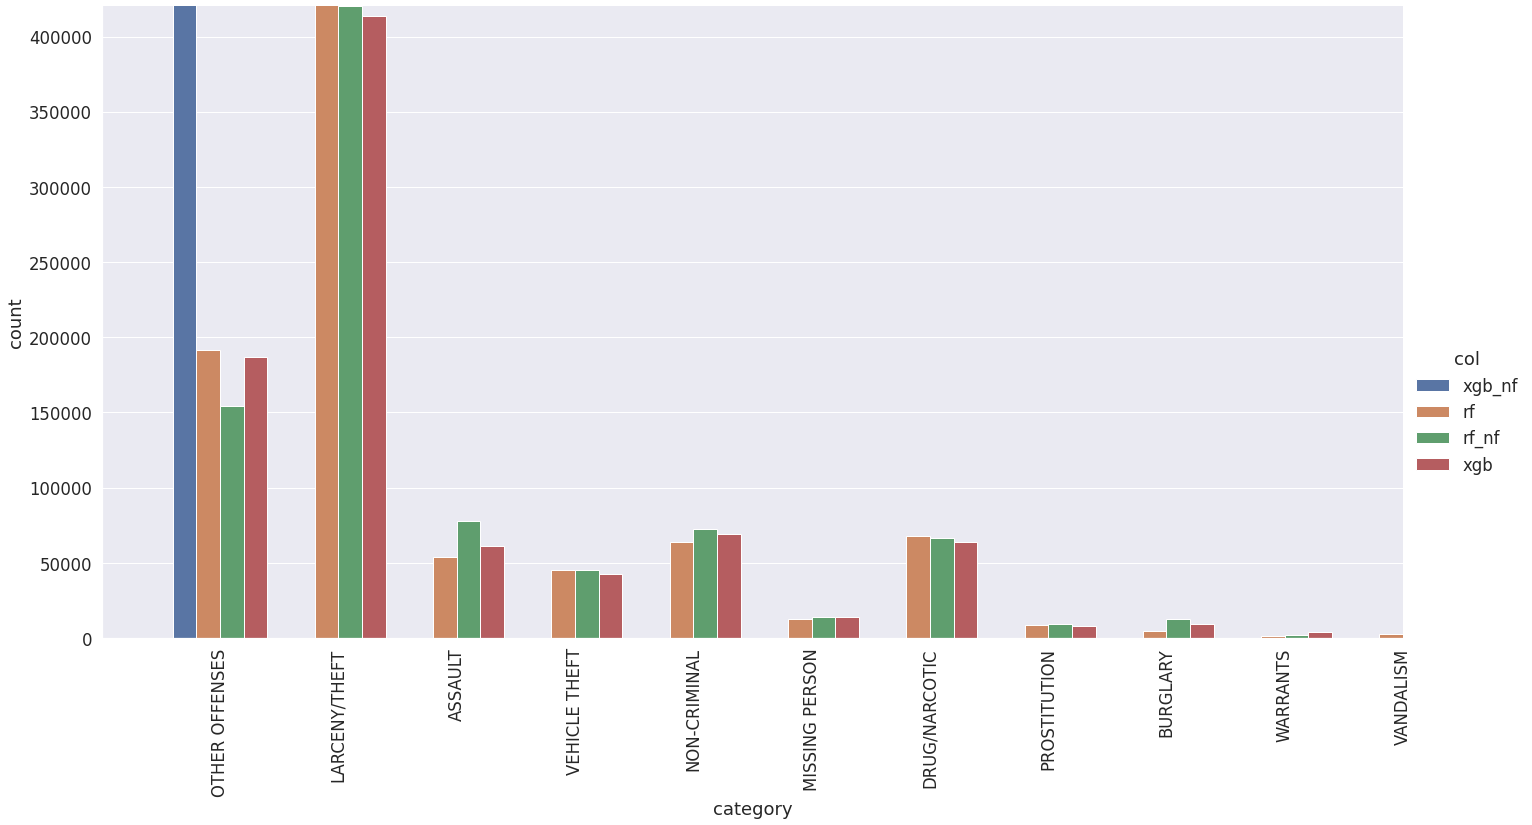

In [ ]:
sns.catplot(data=count_df, x='category', y='count', hue='col', kind='bar', height=10, aspect=2)
sns.set(font_scale=1.5)
plt.xticks(rotation=90)

plt.xlim(-1, 10)
plt.ylim(0, 420000)
plt.show()

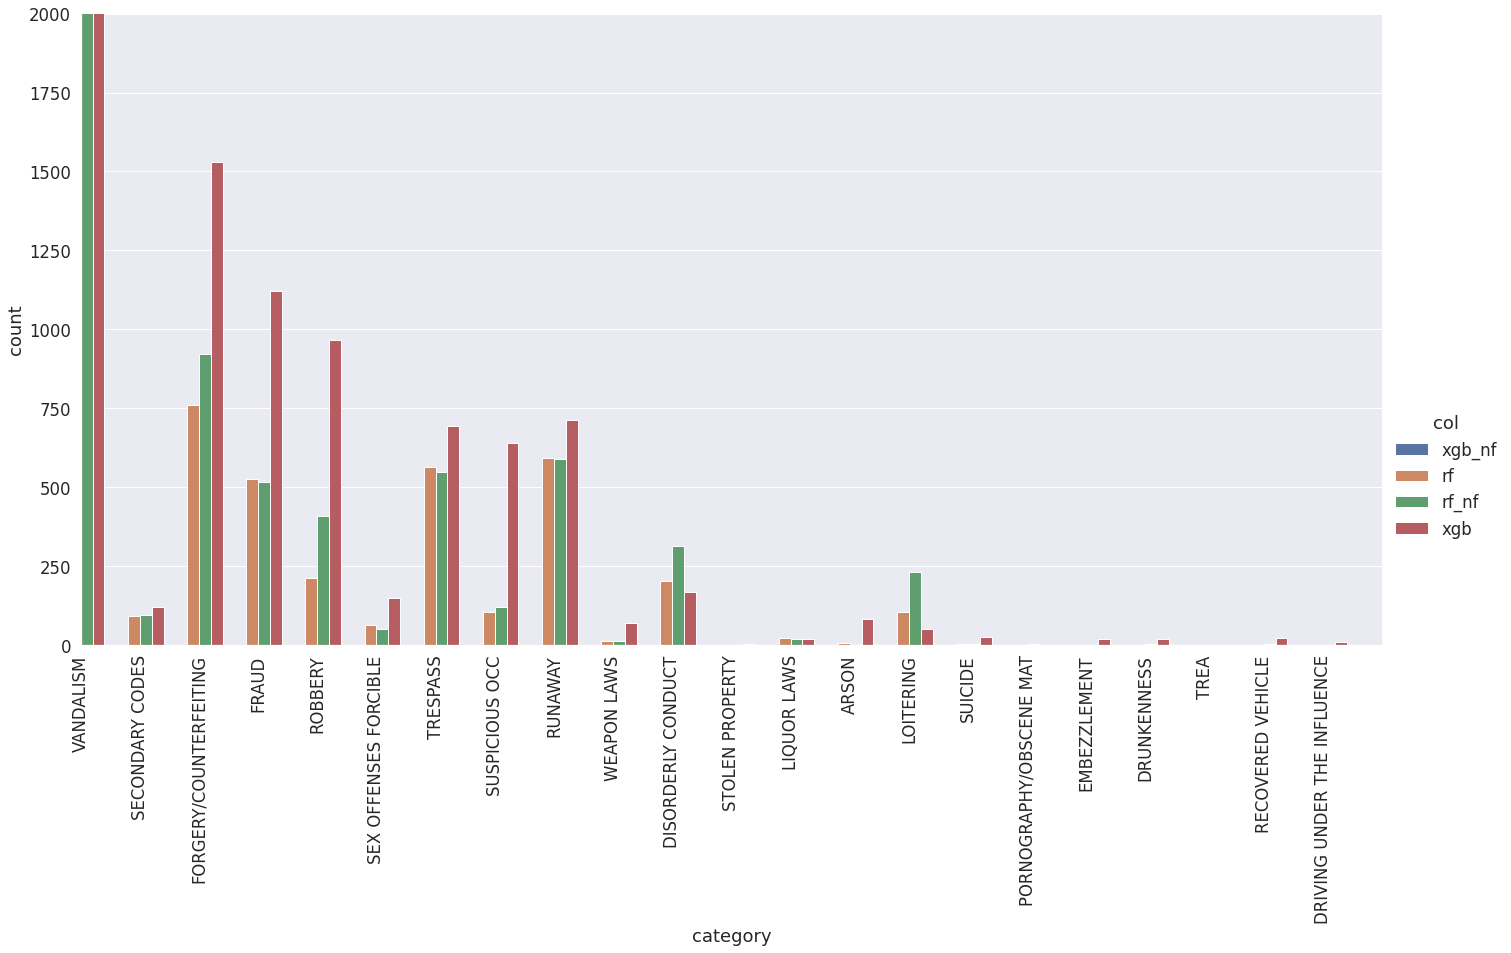

In [ ]:
sns.catplot(data=count_df, x='category', y='count', hue='col', kind='bar', height=10, aspect=2)
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
plt.xlim(10, 32)
plt.ylim(0, 2000)
plt.show()

In [ ]:
df_preds.nunique()

xgb_nf     1
rf        28
rf_nf     30
xgb       31
dtype: int64

In [ ]:
df.Category.nunique()

39

In [ ]:
three_avg = rf.add(rf_nf)
three_avg = three_avg.add(xgb)
three_avg = three_avg.div(3).drop(["Id"], axis = 1)
three_avg = three_avg.reset_index().rename(columns = {"index": "Id"})
three_avg.to_csv("three_avg.csv", index = False)

In [ ]:
rf_nf_xgb = rf_nf.add(xgb)
rf_nf_xgb = rf_nf_xgb.div(2).drop(["Id"], axis = 1)
rf_nf_xgb = rf_nf_xgb.reset_index().rename(columns = {"index": "Id"})
rf_nf_xgb.to_csv("rf_nf_xgb.csv", index = False)

In [ ]:
rf_nf_rf = rf_nf.add(rf)
rf_nf_rf = rf_nf_rf.div(2).drop(["Id"], axis = 1)
rf_nf_rf = rf_nf_rf.reset_index().rename(columns = {"index": "Id"})
rf_nf_rf.to_csv("rf_nf_rf.csv", index = False)